In [1]:
from pathlib import Path
from urllib import request
import time
import os
import functools

if 'CUDA_VISIBLE_DEVICES' not in os.environ:
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"

os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=False'
)

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.95'

import zipfile

import numpy as onp

import jax
import optax
from jax import numpy as jnp, random, vmap, tree_util

In [2]:
from jax_md_mod import io, custom_quantity, custom_space, custom_energy
from jax_md import simulate, partition, space, util, energy, quantity as snapshot_quantity


from jax_md_mod.model import layers, neural_networks, prior

import mdtraj


import matplotlib.pyplot as plt

import haiku as hk
import chex
import copy
import contextlib

from chemtrain.data import preprocessing
from chemtrain.ensemble import sampling
from chemtrain import quantity, trainers, util as chem_util

2024-08-28 10:13:40.599139: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Bottom-Up and Top-Down Training of Atomistic Titanium

## Problem

This example reproduces the results of the paper [Accurate machine learning force fields via experimental and simulation data fusion ](https://www.nature.com/articles/s41524-024-01251-4) [^Roecken2024].

This paper introduces fused bottom-up and top-down learning. We use titanium as a showcase, and train the bottom-up model on DFT forces and energies. The top-down model is trained on experimental elastic constants and pressures.
First, we train a NN potential bottom-up using FM. Second, we train a fused bottom-up and top-down NN potential.

## Loading Bottom-Up Reference Data

In [4]:
def load_subset(data_dir, train_ratio=0.7, val_ratio=0.1):
    box = onp.load(data_dir / 'box.npy', allow_pickle=True)
    coord = onp.load(data_dir / 'coord.npy', allow_pickle=True)
    energy = onp.load(data_dir / 'energy.npy', allow_pickle=True)
    force = onp.load(data_dir / 'force.npy', allow_pickle=True)
    virial = onp.load(data_dir / 'virial.npy', allow_pickle=True)
    type = onp.load(data_dir / 'types.npy', allow_pickle=True)

    # We reshape the data to a standard format
    n_samples = box.shape[0]

    # Transpose box tensor to conform to JAX-MD format
    dataset = dict(
        box=onp.reshape(box, (n_samples, 3, 3)).swapaxes(1, 2),
        R=onp.reshape(coord, (n_samples, -1, 3)),
        U=onp.reshape(energy, (n_samples,)),
        type=onp.reshape(type, (n_samples,)),
        F=onp.reshape(force, (n_samples, -1, 3)),
        virial=onp.reshape(virial, (n_samples, 3, 3))
    )

    # Do not shuffle to use same splits as in the paper
    splits = preprocessing.train_val_test_split(
        dataset, train_ratio=train_ratio, val_ratio=val_ratio, shuffle=False)

    return splits


def get_train_val_test_set(dir_files):
    """This function takes in a list of directories that contain
        box, coord, energy, force, virial npy files and returns for each
        of these properties a train(70%), validation(10%), and test(20%) set in a new format.
        box = np.array(n_structures, np.array(3,3))
        coords = [n_structures, np.array(atoms_strucutre,3)]
        energy = np.array(n_structures)
        force = [n_structures, np.array(atoms_strucutre,3)]
        virial = np.array(n_structures, np.array(3,3))"""

    # Initialize arrays to store the data
    dataset = dict(
        training=dict(box=[], R=[], U=[], F=[], virial=[], type=[]),
        validation=dict(box=[], R=[], U=[], F=[], virial=[], type=[]),
        testing=dict(box=[], R=[], U=[], F=[], virial=[], type=[])
    )

    # Load the data from all provided files
    for i in range(len(dir_files)):
        train_split, val_split, test_split = load_subset(dir_files[i])

        for k in dataset['training'].keys():
            dataset['training'][k].append(train_split[k])
            dataset['validation'][k].append(val_split[k])
            dataset['testing'][k].append(test_split[k])

    # Concatenate to single arrays
    for split in dataset.keys():
        for quantity in dataset[split].keys():
            dataset[split][quantity] = onp.concatenate(dataset[split][quantity], axis=0)

    return dataset


def scale_dataset(dataset, scale_U=1.0, scale_R=1.0, fractional=True):
    """Scales a dataset of positions from real space to fractional coordinates.

    Args:
        traj: A (N_snapshots, N_particles, 3) array of particle positions
        boxes: A (N_snapshots, 1 or 2-dimensional jax_md box)

    Returns:
        A (N_snapshots, N_particles, 3) array of particle positions in
        fractional coordinates.
    """

    scale_F = scale_U / scale_R
    for split in dataset.keys():

        _, scale_fn = custom_space.init_fractional_coordinates(dataset[split]['box'][0])
        vmap_scale_fn = jax.vmap(lambda R, box: scale_fn(R, box=box), in_axes=(0, 0))

        if fractional:
            dataset[split]['R'] = vmap_scale_fn(dataset[split]['R'], dataset[split]['box'])
        else:
            dataset[split]['R'] = dataset[split]['R'] * scale_R

        dataset[split]['box'] *= scale_R
        dataset[split]['U'] *= scale_U
        dataset[split]['F'] *= scale_F
        
        # Scale virial by volume as in the chemntrain implementation and invert
        # the sign.
        volumes = jax.vmap(snapshot_quantity.volume, (None, 0))(3, dataset[split]['box'])
        dataset[split]['virial'] *= -scale_U / volumes[:, None, None]
            
        # Only bulk virials should contribute to the loss. Correct for
        # the reduction in the number of samples
        type = dataset[split]['type']
        virial_weights = (1 - type) / onp.mean(1 - type)
        
        assert onp.all(virial_weights >= 0), "Virial weights should be positive."
        assert onp.isclose(onp.mean(virial_weights), 1.0)
        
        dataset[split]['virial_weights'] = virial_weights
   
    return dataset

The following section downloads the reference data from the original paper[^Roecken2024].

In [5]:
# Load data from the link provided in the paper

url = "https://github.com/tummfm/Fused-EXP-DFT-MLP/raw/main/Dataset/Data_DFT_and_Exp.zip"

data_dir = Path("../_data")
data_dir.mkdir(exist_ok=True)

if not (data_dir / "TI_DFT_EXP").exists():
    request.urlretrieve(url, data_dir / "TI_DFT_EXP.zip")

with zipfile.ZipFile(data_dir / "TI_DFT_EXP.zip") as zip_f:
    zip_f.extractall(data_dir / "TI_DFT_EXP")

dft_path = data_dir / "TI_DFT_EXP" / "Data DFT and EXP" / "DFT_data" / "InitAndBulk_256atoms_curatedData.zip"
with zipfile.ZipFile(dft_path) as zip_f:
    zip_f.extractall(dft_path.parent / "InitAndBulk_256atoms_curatedData")
    
exp_path = data_dir / "TI_DFT_EXP" / "Data DFT and EXP" / "Exp_data" / "Exp_Boxes_AtomPositions" / "ExperimentalLattice_Boxes_AtomPositions.zip"
with zipfile.ZipFile(exp_path) as zip_f:
    zip_f.extractall(exp_path.parent / "ExperimentalLattice_Boxes_AtomPositions")

data_list = [dft_path.parent / "InitAndBulk_256atoms_curatedData" / "261022_AllInitAndBulk_256atoms_with_types_curatedData"]

predef_weights = onp.load(data_list[0] / 'types.npy')
predef_weights = jnp.array(predef_weights)

scale_energy = 96.4853722                  # [eV] ->   [kJ/mol]
scale_pos = 0.1                            # [Å] -> [nm]


dataset = get_train_val_test_set(data_list)
dataset = scale_dataset(dataset, scale_R=scale_pos, scale_U=scale_energy, fractional=True)

## Model definition
To learn the underlying potential energy surface, we employ the grap neural network architecture DimeNet++ [^Gasteiger2020].

In [6]:
print(f"Dataset format: {tree_util.tree_map(jnp.shape, dataset)}")

# Set up NN model
r_init = jnp.asarray(dataset['training']['R'][0])
species_init = jnp.ones_like(r_init[..., 0], dtype=int)
box_init = jnp.asarray(dataset['training']['box'][0])

n_species = 10
r_cut = 0.5

fractional = True
displacement_fn, shift_fn = space.periodic_general(
    box_init, fractional_coordinates=fractional)


neighbor_fn = partition.neighbor_list(
    displacement_fn, box_init, r_cut, disable_cell_list=True,
    fractional_coordinates=fractional, capacity_multiplier=2.5
)

nbrs_init = neighbor_fn.allocate(r_init, extra_capacity=3)
key = random.PRNGKey(21)
mlp_init = {
    'b_init': hk.initializers.Constant(0.),
    'w_init': layers.OrthogonalVarianceScalingInit(scale=1.)
}

max_edges, max_triplets = (12000, 470000)
init_fn, gnn_energy_fn = neural_networks.dimenetpp_neighborlist(
    displacement_fn, r_cut, n_species, embed_size=32, init_kwargs=mlp_init,
    max_edges=max_edges, max_triplets=max_triplets
)

# Load a pretrained model
init_params = onp.load("../_data/output/AT_TI_pretrained_bottom_up.pkl", allow_pickle=True)
init_params = tree_util.tree_map(jnp.asarray, init_params)

def energy_fn_template(energy_params):
    
    def energy_fn(pos, neighbor, **dynamic_kwargs):
        assert 'box' in dynamic_kwargs.keys(), 'box not in dynamic_kwargs'
        
        # We only have one type of particle
        species=jnp.ones(pos.shape[0], dtype=int)
        
        gnn_energy = gnn_energy_fn(
            energy_params, pos, neighbor, species=species, **dynamic_kwargs
        )
        
        return gnn_energy
    return energy_fn

Dataset format: {'testing': {'F': (1142, 256, 3), 'R': (1142, 256, 3), 'U': (1142,), 'box': (1142, 3, 3), 'type': (1142,), 'virial': (1142, 3, 3), 'virial_weights': (1142,)}, 'training': {'F': (3992, 256, 3), 'R': (3992, 256, 3), 'U': (3992,), 'box': (3992, 3, 3), 'type': (3992,), 'virial': (3992, 3, 3), 'virial_weights': (3992,)}, 'validation': {'F': (570, 256, 3), 'R': (570, 256, 3), 'U': (570,), 'box': (570, 3, 3), 'type': (570,), 'virial': (570, 3, 3), 'virial_weights': (570,)}}


## Setting up Bottom-Up Training

In [ ]:
# First define new bottom-up trainer for combined training
initial_lr_fm_1 = 5e-7
num_epochs_fused = 100
fm_batch_size = 30
fm_batch_cache = 8
fm_batch_per_device = fm_batch_size // jax.device_count()

num_transition_steps_fm_1 = int(
    num_epochs_fused * dataset['training']['U'].size
) // fm_batch_per_device


lr_schedule_fm = optax.exponential_decay(initial_lr_fm_1, num_transition_steps_fm_1, 0.01)
optimizer_fm = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_learning_rate(lr_schedule_fm, flip_sign=True)
)

trainer_fm = trainers.ForceMatching(
    init_params, optimizer_fm, energy_fn_template, nbrs_init,
    batch_per_device=fm_batch_per_device,
    batch_cache=fm_batch_cache,
    gammas={
        'virial': 4e-6,'U': 1e-6, 'F': 1e-2
    },
    additional_targets={
        'virial': custom_quantity.init_virial_stress_tensor(
            energy_fn_template, reference_box=None, include_kinetic=False)
    },
    weights_keys={
        'virial': 'virial_weights'
    }
)

trainer_fm.set_dataset(dataset['training'], stage='training')
trainer_fm.set_dataset(dataset['validation'], stage='validation', include_all=True)
trainer_fm.set_dataset(dataset['testing'], stage='testing', include_all=True)

In [8]:
test_predictions = trainer_fm.predict(dataset['testing'], batch_size=fm_batch_size)

Initialize full data pipeline


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explic

[Force] Found precomputed forces.
[Potential] Found precomputed forces.
[Virial] Found precomputed forces.


In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5), layout="constrained")

fig.suptitle("Predictions on Testset")

mae = onp.mean(onp.abs(test_predictions['U'] - dataset['testing']['U'])) / scale_energy / 256
ax1.set_title(f"Energy (MAE: {mae*1000:.1f} meV/atom)")
ax1.plot(dataset['testing']['U'] / scale_energy / 256, test_predictions['U'] / scale_energy / 256, "*")
ax1.set_xlabel("Ref. U [eV/atom]")
ax1.set_ylabel("Pred. U [eV/atom]")

mae = onp.mean(onp.abs(test_predictions['F'] - dataset['testing']['F'])) / scale_energy * scale_pos
ax2.set_title(f"Force (MAE: {mae*1000:.1f} meV/A)")
ax2.plot(dataset['testing']['F'][::50].ravel() / scale_energy * scale_pos, test_predictions['F'][::50].ravel() / scale_energy * scale_pos, "*")
ax2.set_xlabel("Ref. F [eV/A]")
ax2.set_ylabel("Pred. F [eV/A]")

mae = onp.mean(onp.abs(test_predictions['virial'] - dataset['testing']['virial'])) / scale_energy * (scale_pos ** 3)
ax3.set_title(f"Virial (MAE: {mae*1000:.1f} meV/A^3)")
ax3.plot(dataset['testing']['virial'][dataset['testing']['type'] == 0].ravel() / scale_energy * (scale_pos ** 3), test_predictions['virial'][dataset['testing']['type'] == 0].ravel() / scale_energy * (scale_pos ** 3), "*")
ax3.set_xlabel("Ref. W [eV/A^3]")
ax3.set_ylabel("Pred. W [eV/A^3]")

fig.savefig("../_data/output/TI_fm_predictions.pdf", bbox_inches="tight")

## Loading Top-Down Reference Data
Load the top-down learning targets, i.e., experimental elastic constants at 323 and 923 K.

In [10]:
data = onp.loadtxt(data_dir / "TI_DFT_EXP/Data DFT and EXP/Exp_data/Exp_EC/EC_From_ExpLatticeConstants.txt", skiprows=1)

def preprocess_constants(raw_data):
    raw_data *= 100 # to GPa
    elastic_constants = onp.round(raw_data, decimals=1)
    elastic_constants *= 10 ** 3 / 1.66054 #  and from GPa to kJ/mol/nm^3
    
    elastic_constants = elastic_constants[(0, 3, 4, 1, 2),]
    return elastic_constants

# Preprocess the reference data
exp_data = {t: preprocess_constants(r) for t, r in zip(data[:, 0], data[:, 2:])}

In [11]:
# We select only a subset of the reference data
temps = onp.asarray([323, 923])
mass = 47.867  # mass of Ti atoms in u

base_path = data_dir / 'TI_DFT_EXP/Data DFT and EXP/Exp_data/Exp_Boxes_AtomPositions/ExperimentalLattice_Boxes_AtomPositions/ExperimentalLattice_Boxes_AtomPositions'

init_kwargs = {}
state_kwargs = {}
for t in temps:
    
    # Convert from A to nm
    box = jnp.array(onp.load(base_path / f'{t}K_expt_box.npy')) / 10.
    coords = jnp.array(onp.load(base_path / f'{t}K_expt_coordinates.npy')) / 10.
    
    assert coords.shape == (150,3), (
        f"Shape of coordinates at temperatre {t} is {coords.shape}."
    )
    
    init_box, scale_fn = custom_space.init_fractional_coordinates(box)
    
    # Convert temperature to units of kb
    state_kwargs[t] = {
        'kT': jnp.asarray(t * quantity.kb), 'box': init_box
    }
    init_kwargs[t] = {
        'r_init': scale_fn(coords)
    }
    
    assert init_kwargs[t]['r_init'].shape == (150,3)

## Setting up Simulation
We employ molecular dynamics with Langevin dynamics to simulate an NVT ensemble and sample approximately independent states for the top-down learning procedure.

In [12]:
# Setup simulation
gamma_sim = 100
dt = 0.002
total_time_difftre = 20.
t_equilib_difftre = 5.  # discard all states within the first 5 ps as equilibration
print_every_difftre = 0.05  # save states every 0.05 ps for use in averaging

timings = sampling.process_printouts(
    dt, total_time_difftre, t_equilib_difftre, print_every_difftre
)

# All systems have the sambe number of particles, so we can use the first
# system as reference
box_init_difftre = state_kwargs[temps[0]]['box']
r_init_difftre = init_kwargs[temps[0]]['r_init']

displacement_fn, shift_fn = space.periodic_general(box_init_difftre)
neighbor_fn_difftre = partition.neighbor_list(
    displacement_or_metric=displacement_fn, box=box_init_difftre, r_cutoff=r_cut, disable_cell_list=True,
    fractional_coordinates=fractional, capacity_multiplier=2.5
)

nbrs_init_difftre = neighbor_fn_difftre.allocate(r_init_difftre, extra_capacity=1)

init_ref_state, sim_template = sampling.initialize_simulator_template(
    simulate.nvt_langevin, shift_fn=shift_fn, nbrs=nbrs_init_difftre,
    init_with_PRNGKey=True, extra_simulator_kwargs={"dt": dt, "gamma": gamma_sim, "kT": None}
)

# We initialize a simulation state for all temperatures
reference_states = {}
for t in temps:
    key, split = random.split(key)
    
    init_sim_kwargs = {"mass": mass, "neighbor": nbrs_init_difftre}
    init_sim_kwargs.update(state_kwargs[t])
    init_nbrs_kwargs = {"extra_capacity": 1}
    init_nbrs_kwargs.update(state_kwargs[t])
    
    assert init_kwargs[t]['r_init'].shape[0] == nbrs_init_difftre.idx.shape[0], (
        f"Missmatch in neighborlist shape."
    )
    
    reference_state = init_ref_state(
        split, init_kwargs[t]['r_init'], energy_or_force_fn=energy_fn_template(
        init_params), init_sim_kwargs=init_sim_kwargs,
        init_nbrs_kwargs=init_nbrs_kwargs
    )
    
    reference_states[t] = reference_state

/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/reductions.py:213: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


## Setting up Top-Down Targets
The experimental targets are the experimental elastic constants of titanium at $323$ and $939\ \text{K}$, and a pressure of $1\ \text{bar}$.

In [13]:
# Add targets and compute functions
gamma_elastic_contant = 1.e-10
gamma_pressure_scalar = 1.e-9

# We have to define different target values for 
# the statepoints, but can use the same observables
# and snapshot functions
targets = {
    t: {
        'elastic_constants': {
            'target': exp_data[t],
            'gamma': gamma_elastic_contant
        },
        'pressure': {
            'target': jnp.asarray(1. / 16.6054),
            'gamma': gamma_pressure_scalar
        }
    } for t in temps
}

observables = {
    'elastic_constants': quantity.observables.init_born_stiffness_tensor(
            reference_box=None, dof=3 * r_init_difftre.shape[0], kT=None,
            elastic_constant_function=quantity.observables.stiffness_tensor_components_hexagonal_crystal),
    'pressure': quantity.observables.init_traj_mean_fn('pressure')
}

compute_fns = {
    'born_stiffness': custom_quantity.init_stiffness_tensor_stress_fluctuation(
        energy_fn_template, reference_box=None),
    'born_stress': custom_quantity.init_sigma_born(
        energy_fn_template, reference_box=None),
    'pressure': custom_quantity.init_pressure(
        energy_fn_template, reference_box=None)
}

In [14]:
def difftre_log_fn(trainer, *args, **kwargs):
    """Logs the predicted elastic constants for the latest epoch"""
    for key, values in trainer.predictions.items():
        print(f"[Statepoint {key}] Elastic constants:")
        for idx, cst in enumerate(['C11', 'C33', 'C44', 'C12', 'C13']):
            pred = values[trainer._epoch]['elastic_constants'][idx] / 10 ** 3 * 1.66054
            print(f"\t{cst}: {pred:.2f} GPa", flush=True)

## Setting up DiffTRe and Interleaved Trainer
The DiffTRe trainer class denotes the top-down learning procedure. The InterleaveTrainers class is a wrapper around the bottom-up and the top-down trainer.

In [15]:
# Setup optimizer for difftre
check_freq_difftre = 10.
initial_lr_difftre = 0.0002
lr_schedule_difftre = optax.exponential_decay(initial_lr_difftre, num_epochs_fused, 0.1)
optimizer_difftre = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_learning_rate(lr_schedule_difftre, flip_sign=True)
)

trainer_difftre = trainers.Difftre(
    init_params, optimizer_difftre, energy_fn_template=energy_fn_template,
    checkpoint_path=Path('atomistic_titanium/trained_models/checkpoints'),
    sim_batch_size=-1)

# Add a separate statepoint for each temperature. We can re-use the
# snapshot and observable functions for all statepoints
for t in temps:
    trainer_difftre.add_statepoint(
        energy_fn_template, sim_template, neighbor_fn_difftre, timings,
        state_kwargs=state_kwargs[t], quantities=compute_fns,
        reference_state=reference_states[t],
        observables=observables, targets=targets[t])

# Log the predicted elastic constants after each epoch
trainer_difftre.add_task("post_epoch", difftre_log_fn)

trainer_fused = trainers.InterleaveTrainers(
    sequential=True, checkpoint_base_path='atomistic_titanium/trained_models/interleave_trainer',
    reference_energy_fn_template=energy_fn_template, full_checkpoint=False)

trainer_fused.add_trainer(trainer_fm, num_updates=1, name='Force and Energy Matching')
trainer_fused.add_trainer(trainer_difftre, num_updates=1, name='Difftre')

/home/paul/chemtrain-dev/chemtrain/ensemble/reweighting.py:777: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/reductions.py:213: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/reductions.py:213: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explic

Time for trajectory initialization 0: 1.0241082549095153 mins


/home/paul/chemtrain-dev/chemtrain/ensemble/reweighting.py:777: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:195: UserWarning: Explic

Time for trajectory initialization 1: 1.0049342354138693 mins


In [16]:
if os.environ.get("FUSED_TRAINING", "False").lower() == "true":
    with open("../_data/output/Fused_AT_Ti_training.log", "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            start = time.time()
            trainer_fused.train(num_epochs_fused, checkpoint_frequency=10)
            print(f"Total training time: {(time.time() - start) / 3600 : .1f} hours")
    trainer_fused.save_energy_params("../_data/output/Fused_AT_Ti_params.pkl", '.pkl', best=False)
    trainer_fused.save_trainer("../_data/output/Fused_AT_Ti_trainer.pkl", '.pkl')

trainer_fused = onp.load("../_data/output/Fused_AT_Ti_trainer.pkl", allow_pickle=True)
trainer_fused_params = tree_util.tree_map(
    jnp.asarray, onp.load("../_data/output/Fused_AT_Ti_params.pkl", allow_pickle=True)
)

with open("../_data/output/Fused_AT_Ti_training.log") as f:
    print(f.read())

---------Starting trainer Force and Energy Matching for 1 updates -----------
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib

## Postprocessing
To evaluate the model, we plot the elastic constants of the bottom-up model, the fused trained model, and the experimental reference data.

In [17]:
gamma_sim = 100
dt = 0.001
timings = sampling.process_printouts(dt, 70., 10., 0.1)

# Also compute the temperature
compute_fns['kT'] = custom_quantity.temperature
observables['kT'] = quantity.observables.init_traj_mean_fn('kT')

traj_gen = sampling.trajectory_generator_init(
    sim_template, energy_fn_template, timings,
    compute_fns, vmap_batch=2
)

@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None, None))
@functools.partial(jax.vmap, in_axes=(None, 0, 0))
def postprocess_fn(params, reference_states, dynamic_kwargs):
    
    # Simulate a trajectory
    trajectory = traj_gen(params, reference_states, **dynamic_kwargs)
    
    # Compute the observables from the snapshot fns
    predictions = {
        obs_key: obs_fn(trajectory.aux, **dynamic_kwargs)
        for obs_key, obs_fn in observables.items()
    }
    
    return predictions
    
# Stack the trees to use vmap
all_params = chem_util.tree_stack([
    init_params, trainer_fused_params
])
all_reference_states = chem_util.tree_stack(reference_states.values())
all_state_kwargs = chem_util.tree_stack(state_kwargs.values())

In [18]:
if os.environ.get("EVALUATION", "False").lower() == "true":
    
    all_results = postprocess_fn(all_params, all_reference_states, all_state_kwargs)
    
    # Unstack
    fm_results, fused_results = chem_util.tree_unstack(all_results)
    fm_results = {str(temp): val for temp, val in zip(temps, chem_util.tree_unstack(fm_results))}
    fused_results = {str(temp): val for temp, val in zip(temps, chem_util.tree_unstack(fused_results))}
    
    onp.savez(data_dir / "TI_fm_results.npz", **jax.device_get(fm_results))
    onp.savez(data_dir / "TI_fused_results.npz", **jax.device_get(fused_results))

In [19]:
fused_data = onp.load(data_dir / "TI_fused_results.npz", allow_pickle=True)
fm_data = onp.load(data_dir / "TI_fm_results.npz", allow_pickle=True)

{"FM": dict(fm_data), "Fused": dict(fused_data)}

{'FM': {'323': array({'elastic_constants': array([ 91009.64 , 104870.25 ,  21263.48 ,  49063.   ,  41800.855],
        dtype=float32), 'kT': array(2.6705205, dtype=float32), 'pressure': array(-659.3576, dtype=float32)},
        dtype=object),
  '923': array({'elastic_constants': array([69201.984, 88263.58 , 16346.943, 55048.855, 41269.016],
        dtype=float32), 'kT': array(7.673519, dtype=float32), 'pressure': array(-533.306, dtype=float32)},
        dtype=object)},
 'Fused': {'323': array({'elastic_constants': array([ 93646.91 , 109056.25 ,  26251.807,  59004.055,  42608.45 ],
        dtype=float32), 'kT': array(2.6703973, dtype=float32), 'pressure': array(286.09082, dtype=float32)},
        dtype=object),
  '923': array({'elastic_constants': array([73845.07 , 94723.79 , 20090.293, 63285.223, 42714.805],
        dtype=float32), 'kT': array(7.673532, dtype=float32), 'pressure': array(174.39902, dtype=float32)},
        dtype=object)}}

In [20]:
def plot_elastic_constants(ax, idx, predictions, reference, ylabel="C", set_ylim=True):
    ref_values = onp.asarray([consts[idx] for consts in reference.values()])
    ax.plot(list(reference.keys()), ref_values / 10 ** 3 * 1.66054, "k--", linewidth=2.0)
    
    colors = ['#368274', '#C92D39']
    markers = ["o", "X"]
    
    for pred, col, mar in zip(predictions, colors, markers):
        temps = [float(temp) for temp in pred.keys()]
        preds = onp.asarray([vals.tolist()['elastic_constants'][idx] for vals in pred.values()])
        
        ax.plot(
            temps, preds / 10 ** 3 * 1.66054, mar, color="white", markersize=9, markeredgewidth=2.0,
            markeredgecolor=col)
    
    ax.set_ylabel(ylabel)
    
    if set_ylim:
        lower, upper = ax.get_ylim()
        lower = onp.floor(lower / 10) * 10
        upper = onp.ceil(upper / 10) * 10

        ax.set_ylim([lower, upper])
        ax.set_yticks(onp.arange(lower, upper + 1, 10))
                
    return ax

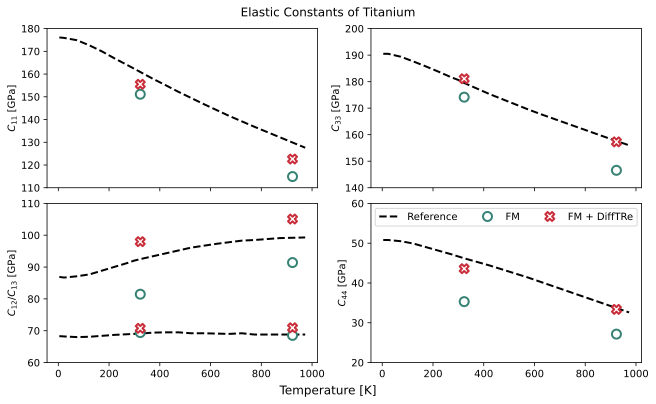

In [21]:
fig, axes = plt.subplots(2, 2, layout="constrained", sharex=True, figsize=(9, 5.5))

all_preds = [fm_data, fused_data]
labels = ["Reference", "FM", "FM + DiffTRe"]

ax1, ax2, ax3, ax4 = onp.ravel(axes)
plot_elastic_constants(ax1, 0, all_preds, exp_data, "$C_{11}$ [GPa]")

plot_elastic_constants(ax2, 1, all_preds, exp_data, "$C_{33}$ [GPa]")

plot_elastic_constants(ax3, 3, all_preds, exp_data, "$C_{12}/C_{13}$ [GPa]", set_ylim=False)
plot_elastic_constants(ax3, 4, all_preds, exp_data, "$C_{12}/C_{13}$ [GPa]")

plot_elastic_constants(ax4, 2, all_preds, exp_data, "$C_{44}$ [GPa]")
ax4.legend(labels, loc="upper center", ncol=3)


fig.supxlabel("Temperature [K]")
fig.suptitle("Elastic Constants of Titanium")

fig.savefig("../_data/output/TI_elastic_constants.pdf", bbox_inches="tight")

## References

[^Roecken2024]: Röcken, Sebastien, and Julija Zavadlav. "Accurate machine learning force fields via experimental and simulation data fusion." npj Computational Materials 10.1 (2024): 69. <https://www.nature.com/articles/s41524-024-01251-4>
[^Gasteiger2020]: Gasteiger, J.; Giri, S.; Margraf, J. T.; Günnemann, S. Fast and Uncertainty-Aware Directional Message Passing for Non-Equilibrium Molecules. <http://arxiv.org/abs/2011.14115>